In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse

In [2]:
def importa_fluke(archivo):
    tmp = pd.read_csv(archivo,usecols=[7,11],names=["fluke","tiempo"],skiprows=1)
    tmp.tiempo = pd.to_datetime(tmp.tiempo,dayfirst=True)
    tmp.set_index("tiempo",inplace=True)
    tmp.fluke = tmp.fluke.str.replace(" ppm","")
    tmp.fluke = tmp.fluke.astype("float64")
    return tmp



In [3]:
archivo = "../../data/fluke_20-07-2021_prueba.csv"
fluke = importa_fluke(archivo)
# fluke.head(3)


In [4]:
tb = pd.read_csv("../../data/sensores_20-07-2021.csv",index_col=0,parse_dates=True)



In [5]:
intervalo = "1S"
def analiza_sensor(df,fluke,sensor="None",intervalo="1S",
                   int_promedio="5Min"):
    tmp = pd.DataFrame(df[sensor])
    tmp.dropna(inplace=True)
    tmp["derivada"]     = tmp.diff().rolling(intervalo).mean()
    tmp["tiempo"]       = tmp.index
    tmp["transcurrido"] = tmp.tiempo - tmp.tiempo.iloc[0]
    
    grafica_sensor(tmp,fluke,intervalo)
    
#     tmp[tmp.derivada<=0].head(1).values
    resultados = obtiene_resultados(tmp,sensor,int_promedio)
    return resultados


def grafica_sensor(df,fluke,intervalo):
    fig, ax = plt.subplots(2,figsize=(12,10),sharex=True)
    nombre = df.columns
    ax[0].plot(df[nombre[0]].rolling(intervalo).mean(),"go",label=nombre[0])
    ax[0].plot(fluke.fluke.rolling(intervalo).mean(),"ro",label='fluke')
    ax[0].set_ylabel("$CO_2$ [ppm]")
    ax[1].plot(df.derivada,"ko",label=nombre[0])
    ax[1].set_ylabel("$\dfrac{d CO_2}{dt}$")
    ax[1].set_xlabel("Fecha [dd hh:mm]")
    for figura in range(2):
        ax[figura].grid()
        ax[figura].legend() 
def obtiene_resultados(tmp,sensor,int_promedio):
    TR  = tmp.transcurrido[tmp.derivada<=0]  
    M   = tmp[sensor].rolling(int_promedio).mean()
    D_r = fluke.fluke.rolling(int_promedio).mean() 
    Error= M.iloc[-1] - D_r.iloc[-1]
    nombre = str(int(D_r.iloc[-1]))+ 'ppm'
    my_dict= {"TR+":TR.iloc[0],  
              "M":M[-1],
              "D_r":D_r.iloc[-1],
              "Error":Error
             }
    resultados = pd.DataFrame(list(my_dict.items()),columns = ['Variable',nombre]) 
    resultados.set_index("Variable",inplace=True)
    return resultados


,893ppm
Variable,
TR+,0 days 00:07:21.616000
M,858.0
D_r,893.9
Error,-35.9


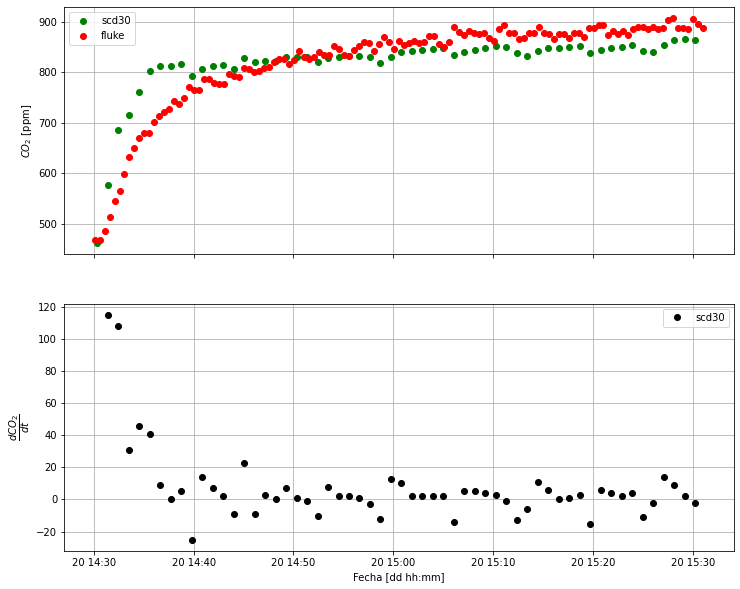

In [6]:
analiza_sensor(tb,fluke,sensor="scd30")